In [2]:
import os
import random
import warnings
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure, feature, color, io 
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, 
    f1_score, precision_score, recall_score
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint

warnings.filterwarnings('ignore')

In [3]:
# Check if a GPU is available and set it as the default device
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using GPU.")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


## Importing Datasets

In [ ]:
# Set base directory
base_dir = r"D:\Documents\cnn\Data Set 1" # Change this to the directory where the dataset is stored

data_directories = {
    "train": os.path.join(base_dir, "train"),
    "val": os.path.join(base_dir, "val"),
    "test": os.path.join(base_dir, "test")
}

## Exploratory Data Analysis (EDA)

In [5]:
# ImageDataGenerator for training, validation, and testing
gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

generators = {name: gen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=(name != "test")  # Don't shuffle test set
) for name, directory in data_directories.items()}

# Helper function to get class names and image counts
def get_class_counts(directory):
    try:
        class_names = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
        class_counts = [len([img for img in os.scandir(os.path.join(directory, class_name)) if img.is_file()]) for class_name in class_names]
        return class_names, class_counts
    except FileNotFoundError:
        print(f"Directory not found: {directory}")
        return [], []


Found 40002 images belonging to 2 classes.
Found 12360 images belonging to 2 classes.
Found 5227 images belonging to 2 classes.


### Class Distribution

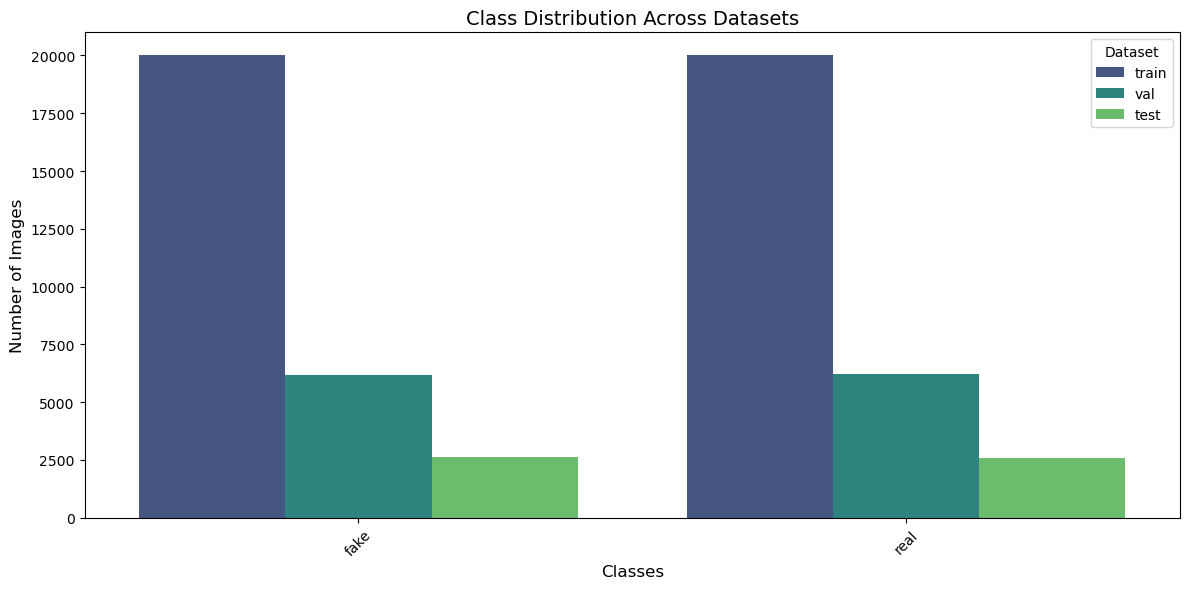

In [ ]:
# Function to visualize class distribution across multiple datasets
def class_distribution_plot(data_directories):
    all_counts = []
    
    for name, directory in data_directories.items():
        class_names, class_counts = get_class_counts(directory)
        df = pd.DataFrame({'Class': class_names, 'Count': class_counts, 'Dataset': name})
        all_counts.append(df)
    
    if not all_counts:
        print("No valid directories to process.")
        return

    combined_df = pd.concat(all_counts, ignore_index=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=combined_df, palette='viridis')
    plt.title('Class Distribution Across Datasets', fontsize=14)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


class_distribution_plot(data_directories)

### Sample Images

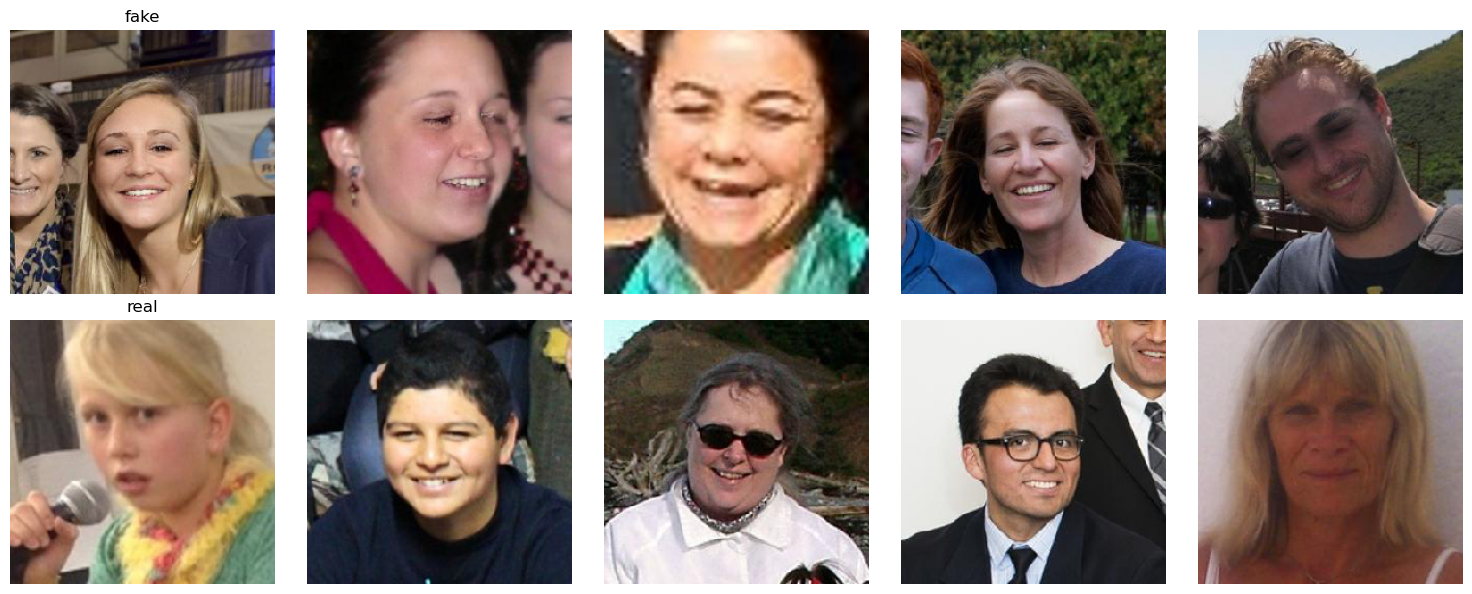

In [7]:
def display_sample_images(directory, num_samples=5):
    class_names, _ = get_class_counts(directory)
    if not class_names:
        print("No classes found in the directory.")
        return

    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, len(class_names) * 3))
    axes = axes.flatten() if len(class_names) > 1 else [axes]

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        sample_images = [img.name for img in os.scandir(class_dir) if img.is_file()][:num_samples]

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(224, 224))
            ax = axes[i * num_samples + j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=12)

    plt.tight_layout()

display_sample_images(data_directories["train"])

### Basic Statistics

In [8]:
# Function to get basic dataset statistics
def get_dataset_statistics(directory, dataset_name):
    class_names, class_counts = get_class_counts(directory)
    total_images = sum(class_counts)
    stats = {
        'Class': class_names + [f'Total_{dataset_name}'],
        'Count': class_counts + [total_images],
        'Dataset': [dataset_name] * len(class_names) + [dataset_name]
    }
    return pd.DataFrame(stats)

# Get dataset statistics for each dataset and display as table
all_stats = []
for name, directory in data_directories.items():
    stats_df = get_dataset_statistics(directory, name)
    all_stats.append(stats_df)

combined_stats_df = pd.concat(all_stats, ignore_index=True)
pivot_table = combined_stats_df.pivot(index='Class', columns='Dataset', values='Count').fillna(0)
display(pivot_table)

Dataset,test,train,val
Class,,,
Total_test,5227.0,0.0,0.0
Total_train,0.0,40002.0,0.0
Total_val,0.0,0.0,12360.0
fake,2623.0,20001.0,6161.0
real,2604.0,20001.0,6199.0


### Image Size Distribution

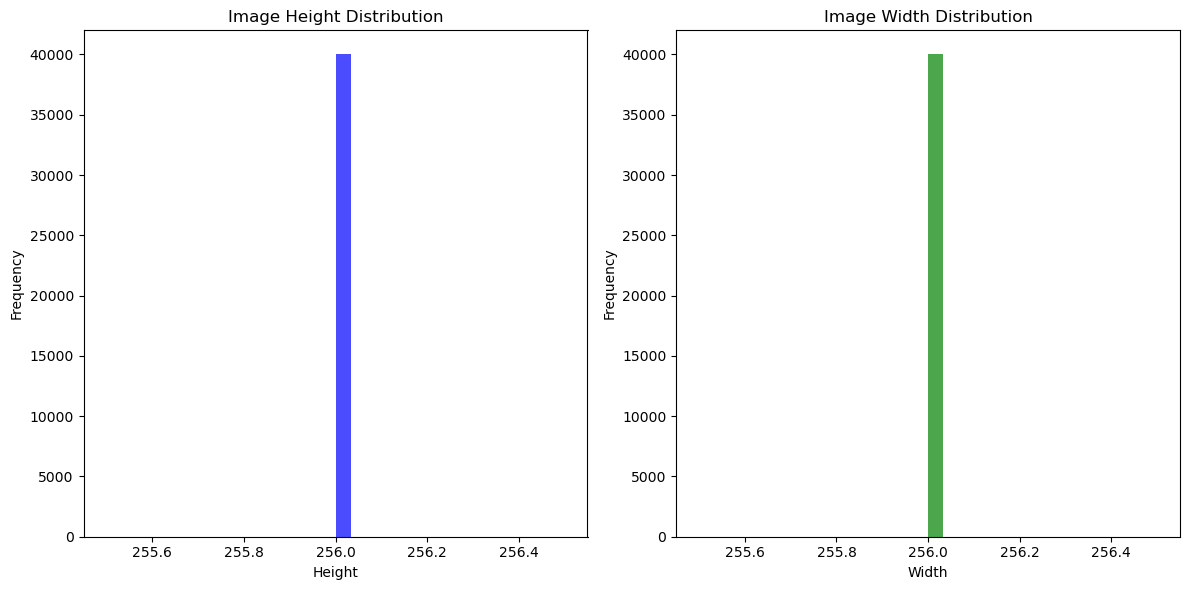

In [9]:
# Analyze the distribution of image sizes in your dataset to understand if there are any significant variations.

def analyze_image_sizes(directory):
    image_sizes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    image_sizes.append(img.shape[:2])  # (height, width)
    
    heights, widths = zip(*image_sizes)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=30, color='blue', alpha=0.7)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=30, color='green', alpha=0.7)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Analyze image sizes in the training directory
analyze_image_sizes(data_directories["train"])

### Aspect Ratio Distribution

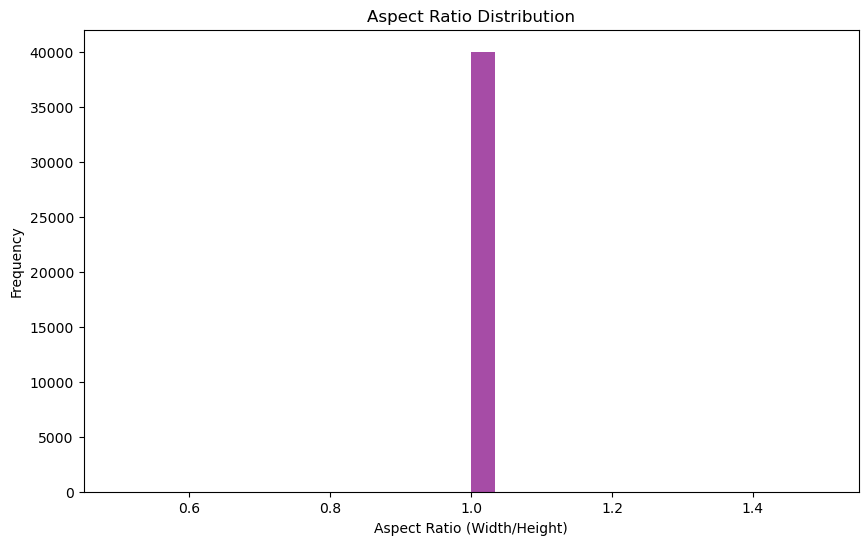

In [10]:
# Analyze the aspect ratio of images to understand if there are any common patterns.

def analyze_aspect_ratios(directory):
    aspect_ratios = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width = img.shape[:2]
                    aspect_ratios.append(width / height)
    
    plt.figure(figsize=(10, 6))
    plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.show()

# Analyze aspect ratios in the training directory
analyze_aspect_ratios(data_directories["train"])

### Contrast Distribution

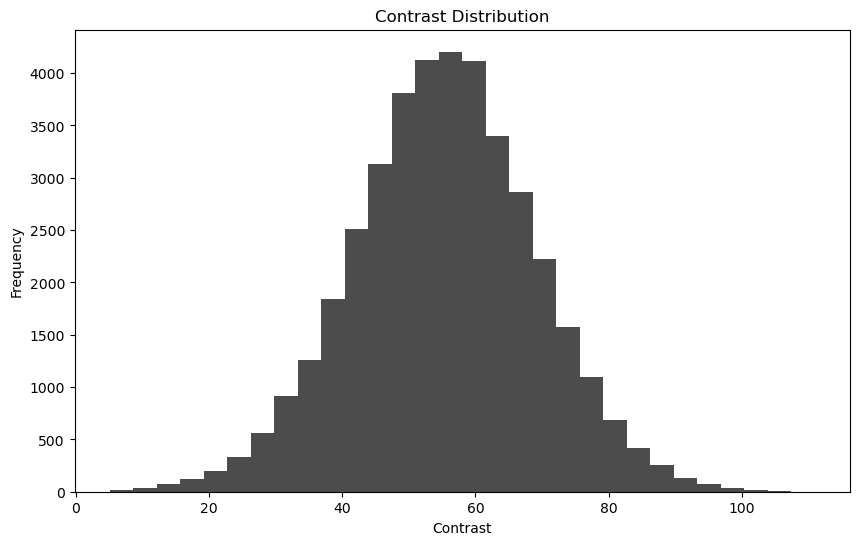

In [11]:
# Analyze the contrast distribution of images to understand the overall contrast levels.

def analyze_contrast_distribution(directory):
    contrast_values = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    contrast_values.append(np.std(gray_img))
    
    plt.figure(figsize=(10, 6))
    plt.hist(contrast_values, bins=30, color='black', alpha=0.7)
    plt.title('Contrast Distribution')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')
    plt.show()

# Analyze contrast distribution in the training directory
analyze_contrast_distribution(data_directories["train"])

### Image Brightness Distribution

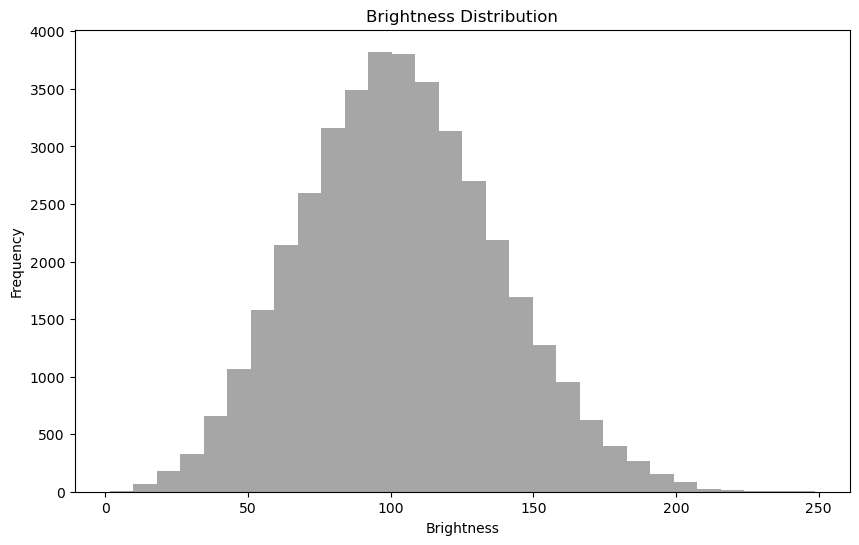

In [12]:
# Analyze the brightness distribution of images to understand the overall lighting conditions.

def analyze_brightness_distribution(directory):
    brightness_values = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    brightness_values.append(np.mean(gray_img))
    
    plt.figure(figsize=(10, 6))
    plt.hist(brightness_values, bins=30, color='gray', alpha=0.7)
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')
    plt.show()

# Analyze brightness distribution in the training directory
analyze_brightness_distribution(data_directories["train"])

# Preprocessing

In [13]:
# Set parameters for image preprocessing
image_size = (150, 150)
batch_size = 32

# Custom ImageDataGenerator with histogram equalization
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        generator = super().flow_from_directory(*args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            # Apply histogram equalization to each image in the batch
            batch_x = np.array([equalize_image(img) for img in batch_x])
            yield batch_x, batch_y

# Function for histogram equalization
def equalize_image(image):
    # Convert image to LAB color space, equalize the L-channel, then convert back to RGB
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # The L channel is assumed to be normalized (0-1) so we scale to 0-255 first
    l_eq = cv2.equalizeHist((l * 255).astype(np.uint8))
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

# Helper function to create ImageDataGenerators
def create_data_generators(train_dir, val_dir, test_dir, custom_augmentation=False):
    # Use the custom ImageDataGenerator if custom_augmentation is True
    if custom_augmentation:
        datagen_class = CustomImageDataGenerator
    else:
        datagen_class = ImageDataGenerator

    train_datagen = datagen_class(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    # For validation and testing, only rescaling is applied
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False,
    )

    return train_generator, val_generator, test_generator

# Function to display preprocessed images from a generator
def display_preprocessed_images(generator, num_samples=5):
    plt.figure(figsize=(10, 10))
    img_batch, label_batch = next(generator)
    for i in range(min(num_samples, len(img_batch))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_batch[i])
        plt.title(f"Label: {label_batch[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Function to extract HOG features from an image
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    hog_features = hog(
        gray_image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=False,
    )
    return hog_features

# Function to load images from a folder and extract HOG features
def load_images_and_extract_features(folder, valid_extensions=None):
    if valid_extensions is None:
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

    features, labels = [], []
    for filename in os.listdir(folder):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            img_path = os.path.join(folder, filename)
            img = io.imread(img_path)
            if img is not None:
                features.append(extract_hog_features(img))
                labels.append(filename.split("_")[0])  # Assumes filename format "label_image.jpg"
        else:
            print(f"Skipped file: {filename}")

    return np.array(features), np.array(labels)

### Displaying Preprocessed Images

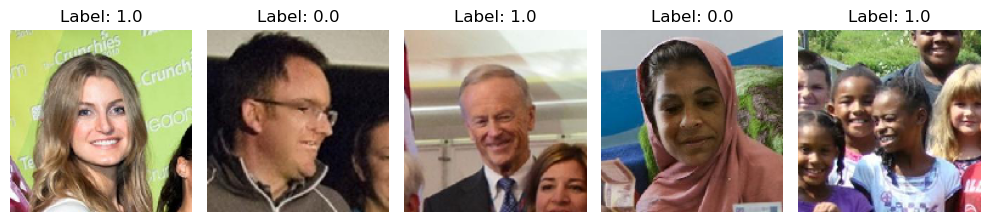

In [14]:
# Display preprocessed images from training set
display_preprocessed_images(generators["train"])

### Extracting HOG features

In [15]:
# Load images and extract HOG features from the training directory
train_features, train_labels = load_images_and_extract_features(data_directories["train"])

Skipped file: fake
Skipped file: real


### Flattening and Standard Scaling

In [16]:
# If necessary, flatten the features and apply standard scaling
def preprocess_features(features, flatten=False, scale=True):
    if flatten:
        features = features.reshape(features.shape[0], -1)
    if scale:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    return

## Feature Extraction

In [ ]:
# Function to load images and labels
def load_images_and_labels(dataset_dir, target_size=(64, 64), classes=None):
    images, labels = [], []
    if classes is None:
        classes = os.listdir(dataset_dir)  # Use all subdirectories as classes

    for label in classes:
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                img = load_img(img_path, target_size=target_size)
                images.append(img_to_array(img))
                labels.append(label)

    return np.array(images), np.array(labels)

# Function to flatten image data
def flatten_images(images):
    n_samples, height, width, channels = images.shape
    return images.reshape(n_samples, -1)

# Function to plot explained variance by PCA components
def plot_explained_variance(pca, threshold=0.95):
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold * 100)}% Variance Threshold')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot t-SNE results
def plot_tsne(X_tsne, labels, label_encoder):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of PCA-Reduced Image Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid()
    plt.show()

# Main Execution
dataset_dir = r'D:\Documents\cnn\Data Set 1\train' # Change this to the directory where the dataset is stored
classes = ['real', 'fake']  

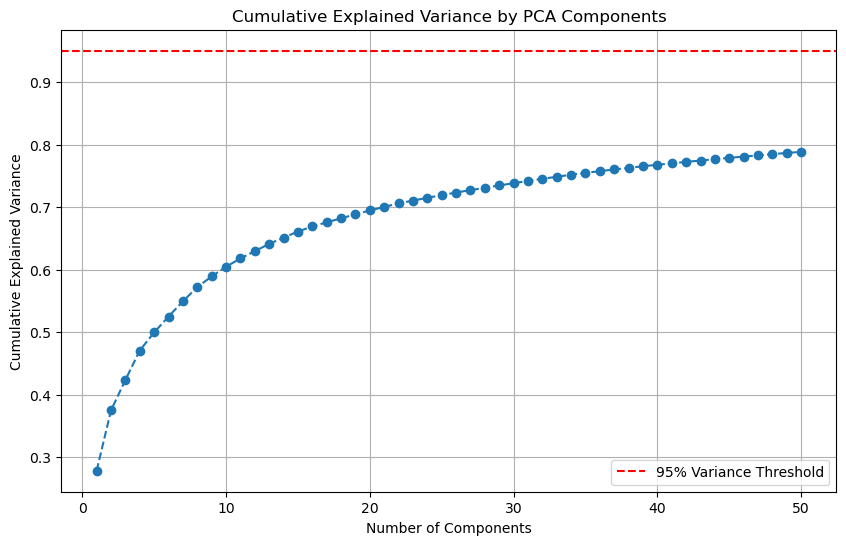

In [18]:
# Load images and labels
X, y = load_images_and_labels(dataset_dir, target_size=(64, 64), classes=classes)

# Flatten the image data
X_flat = flatten_images(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_flat)

# Plot explained variance
plot_explained_variance(pca)


## Model Building

In [6]:
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [20]:
def create_model(model_type):
    if model_type == "custom_cnn":
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
    elif model_type == "inception":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False
    elif model_type == "mobilenet":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric]
    )
    return model

In [21]:
def train_model(model, train_gen, val_gen, model_name):
    print(f"Training {model_name} for 4 epochs...")
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=4,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    return history

In [ ]:
custom_cnn_model = create_model("custom_cnn")
cnn_history = train_model(custom_cnn_model, generators['train'], generators['val'], "Custom CNN")

inception_model = create_model("inception")
inception_history = train_model(inception_model, generators['train'], generators['val'], "Inception V3")

mobilenet_model = create_model("mobilenet")
mobilenet_history = train_model(mobilenet_model, generators['train'], generators['val'], "MobileNetV2")

Training Custom CNN for 4 epochs...
Epoch 1/4
1250/1250 [==============================] - 1078s 858ms/step - loss: 0.5492 - accuracy: 0.7141 - precision: 0.7154 - recall: 0.7111 - f1_metric: 0.6909 - val_loss: 0.5164 - val_accuracy: 0.7442 - val_precision: 0.7141 - val_recall: 0.8169 - val_f1_metric: 0.7569
Epoch 2/4
1250/1250 [==============================] - 1479s 1s/step - loss: 0.3686 - accuracy: 0.8358 - precision: 0.8355 - recall: 0.8361 - f1_metric: 0.8304 - val_loss: 0.3777 - val_accuracy: 0.8329 - val_precision: 0.8157 - val_recall: 0.8617 - val_f1_metric: 0.8335
Epoch 3/4
1250/1250 [==============================] - 983s 787ms/step - loss: 0.2562 - accuracy: 0.8930 - precision: 0.8929 - recall: 0.8932 - f1_metric: 0.8903 - val_loss: 0.3422 - val_accuracy: 0.8570 - val_precision: 0.8220 - val_recall: 0.9125 - val_f1_metric: 0.8624
Epoch 4/4
1250/1250 [==============================] - 886s 707ms/step - loss: 0.2119 - accuracy: 0.9112 - precision: 0.9087 - recall: 0.9143 - f1

## Evaluation

In [4]:
# Function to summarize model performance
def summarize_model_performance(y_true, y_pred, model_name):
    y_pred_classes = np.round(y_pred)  # Convert probabilities to class labels
    accuracy = np.mean(y_pred_classes == y_true)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)
    
    print(f"{model_name} Performance Summary:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

In [24]:
# Plot training and validation accuracy
def plot_accuracy(histories, model_names):
    plt.figure(figsize=(10, 6))
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [25]:
# Plot training and validation loss
def plot_loss(histories, model_names):
    plt.figure(figsize=(10, 6))
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

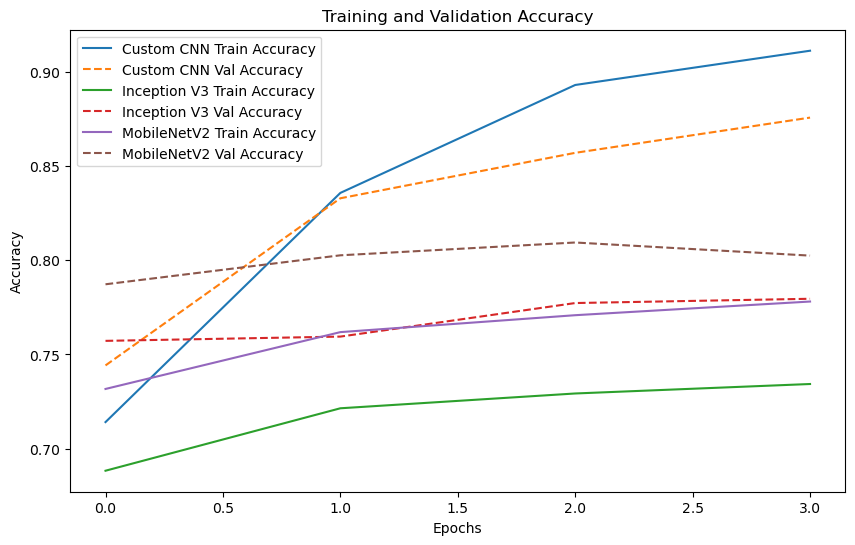

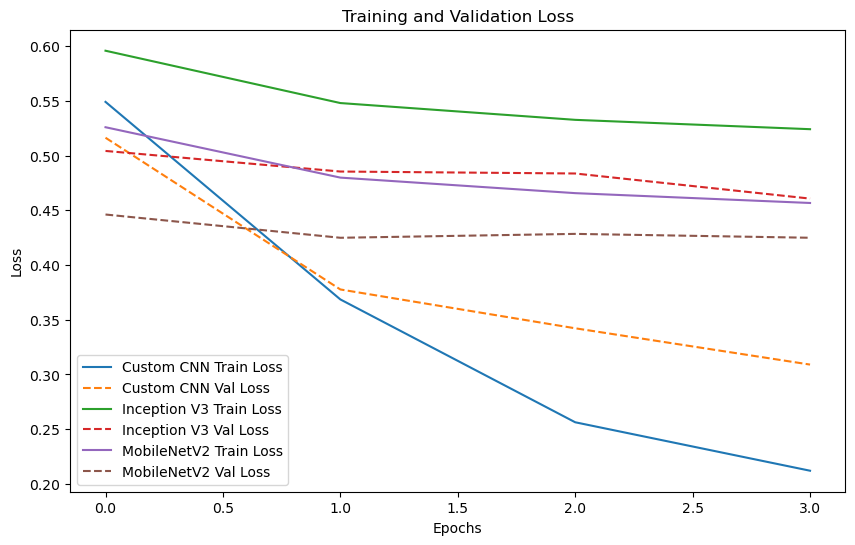

In [26]:
# Plot accuracy and loss for all models
plot_accuracy([cnn_history, inception_history, mobilenet_history], ["Custom CNN", "Inception V3", "MobileNetV2"])
plot_loss([cnn_history, inception_history, mobilenet_history], ["Custom CNN", "Inception V3", "MobileNetV2"])

In [30]:
# Get true labels
y_true = generators['test'].classes

# Predictions
y_pred_cnn = custom_cnn_model.predict(generators['test']).flatten()
y_pred_inception = inception_model.predict(generators['test']).flatten()
y_pred_mobilenet = mobilenet_model.predict(generators['test']).flatten()

# Summarize model performance
summarize_model_performance(y_true, y_pred_cnn, 'Custom CNN')
summarize_model_performance(y_true, y_pred_inception, 'Inception V3')
summarize_model_performance(y_true, y_pred_mobilenet, 'MobileNetV2')


164/164 [==============================] - 92s 549ms/step
Custom CNN Performance Summary:
Accuracy: 0.78
Precision: 0.74
Recall: 0.85
F1 Score: 0.79

Inception V3 Performance Summary:
Accuracy: 0.74
Precision: 0.80
Recall: 0.65
F1 Score: 0.72

MobileNetV2 Performance Summary:
Accuracy: 0.68
Precision: 0.83
Recall: 0.46
F1 Score: 0.59



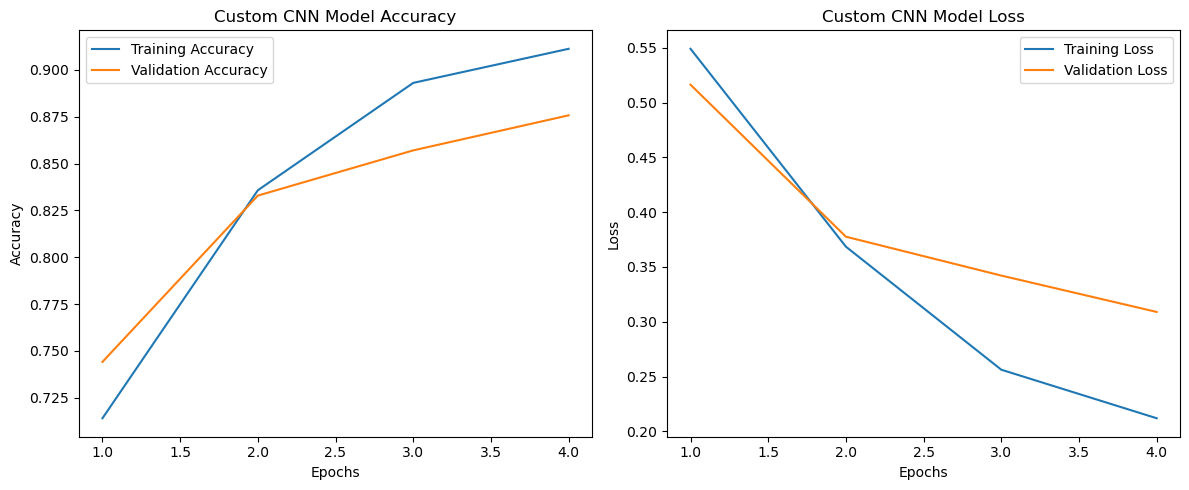

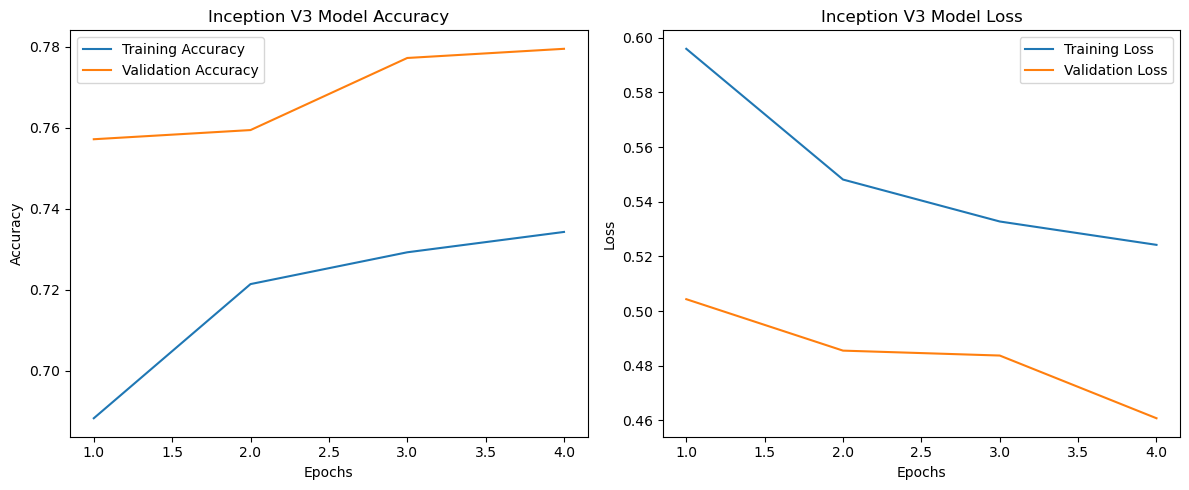

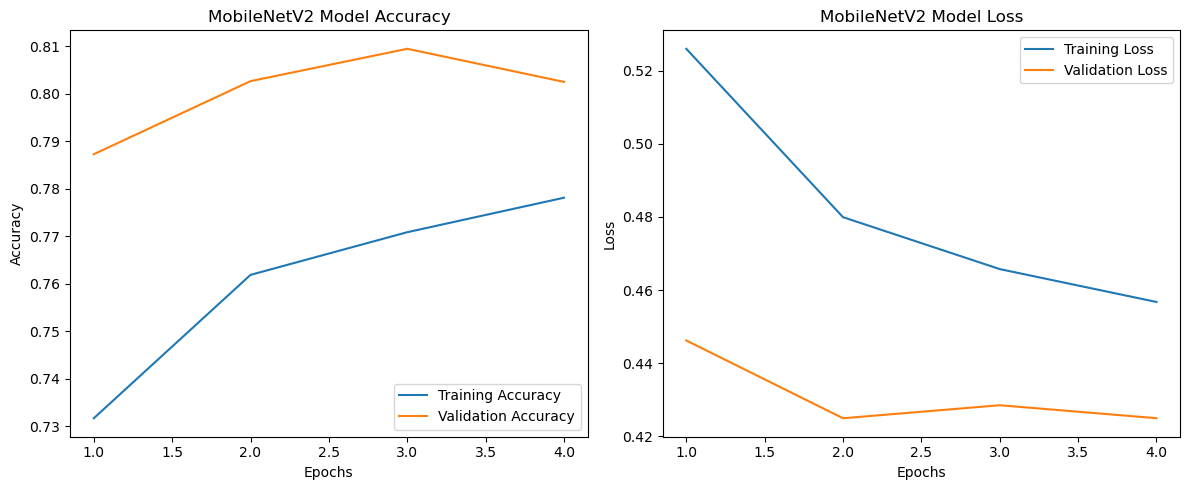

In [28]:
# Plot accuracy and loss
def plot_accuracy_loss(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting accuracy and loss for each model
plot_accuracy_loss(cnn_history, "Custom CNN")
plot_accuracy_loss(inception_history, "Inception V3")
plot_accuracy_loss(mobilenet_history, "MobileNetV2")

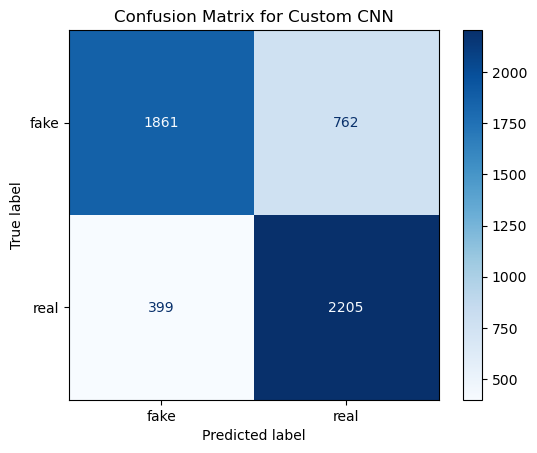

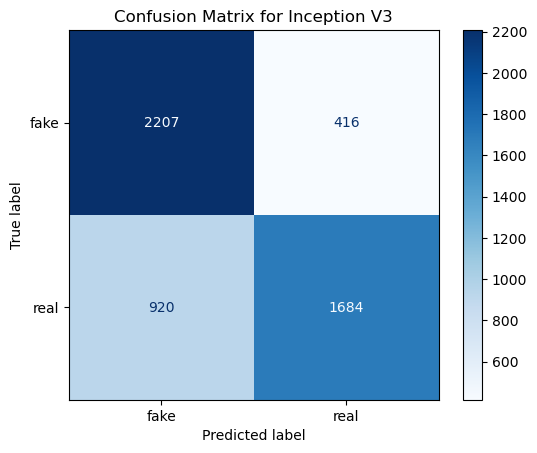

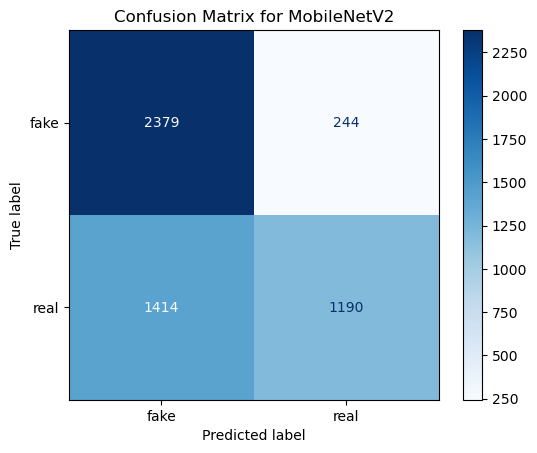

In [31]:
# Function to compute confusion matrix and plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    y_pred_classes = np.round(y_pred)  # Convert probabilities to class labels
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generators['test'].class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Get true labels
y_true = generators['test'].classes

# Plot confusion matrices for each model
plot_confusion_matrix(y_true, y_pred_cnn, 'Custom CNN')
plot_confusion_matrix(y_true, y_pred_inception, 'Inception V3')
plot_confusion_matrix(y_true, y_pred_mobilenet, 'MobileNetV2')

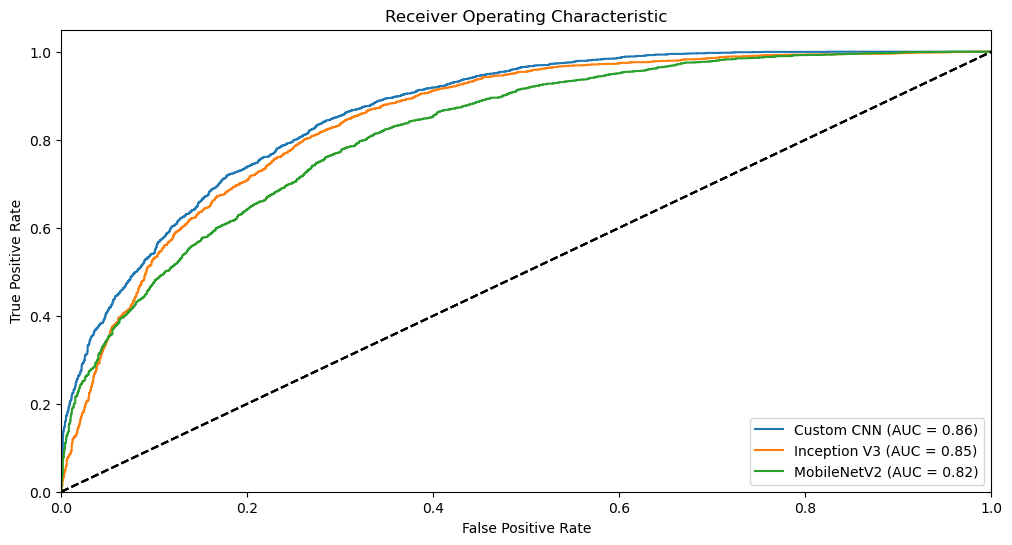

In [32]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

# Plot ROC curves for each model
plt.figure(figsize=(12, 6))
plot_roc_curve(y_true, y_pred_cnn, 'Custom CNN')
plot_roc_curve(y_true, y_pred_inception, 'Inception V3')
plot_roc_curve(y_true, y_pred_mobilenet, 'MobileNetV2')
plt.show()

## Saving Trained Model

In [ ]:
# Define the model (example with Sequential API)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Path where the model will be saved
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # Mode for the monitored metric
    verbose=1                  # Verbosity mode
)

# Train the model with the callback
history = model.fit(
    generators['train'],
    validation_data=generators['val'],
    epochs=20,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
1251/1251 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.7499
Epoch 1: val_accuracy improved from -inf to 0.72638, saving model to best_model.h5
1251/1251 [==============================] - 2199s 2s/step - loss: 0.5352 - accuracy: 0.7499 - val_loss: 0.5501 - val_accuracy: 0.7264
Epoch 2/20
1251/1251 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8276
Epoch 2: val_accuracy improved from 0.72638 to 0.74482, saving model to best_model.h5
1251/1251 [==============================] - 452s 361ms/step - loss: 0.3830 - accuracy: 0.8276 - val_loss: 0.5328 - val_accuracy: 0.7448
Epoch 3/20
1251/1251 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8678
Epoch 3: val_accuracy improved from 0.74482 to 0.75850, saving model to best_model.h5
1251/1251 [==============================] - 479s 383ms/step - loss: 0.2971 - accuracy: 0.8678 - val_loss: 0.5568 - val_accuracy: 0.7585
Epoch 4/20
1251/1251 [====================

## Validating The Model

In [7]:
# Function to preprocess the uploaded image
def preprocess_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to load the trained model
def load_trained_model(model_path):
    return tf.keras.models.load_model(model_path, custom_objects={'f1_metric': f1_metric})

# Function to classify the uploaded image
def classify_image(image_path, model):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    class_label = 'fake' if prediction[0] < 0.5 else 'real'
    confidence = 1 - prediction[0] if class_label == 'fake' else prediction[0]
    return class_label, confidence

# Example usage
model_path = 'best_model.h5'  # Replace with the path to your trained model
uploaded_image_path = r'D:\Documents\cnn\Data Set 1\val\fake\fake_524.jpg'  # Replace with the path to the uploaded image

# Load the trained model
model = load_trained_model(model_path)

# Classify the uploaded image
class_label, confidence = classify_image(uploaded_image_path, model)

# Display the result
print(f'The uploaded image is classified as {class_label} with a confidence of {confidence[0]:.2f}')

1/1 [==============================] - 2s 2s/step
The uploaded image is classified as fake with a confidence of 1.00
